In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
author = str.lower(input('Welcome! Who are you? ')[0])

dict_root = {
    'k': '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/DL_Project',
    'z': '/content/gdrive/.shortcut-targets-by-id/1y_zUgsIhHuKQ5TIkhH4tDM4v2FZNUasQ/DL_Project/',
    'r': '/content/gdrive/.shortcut-targets-by-id/1y_zUgsIhHuKQ5TIkhH4tDM4v2FZNUasQ/DL_Project/'
}

if author in dict_root.keys():
  project_root = dict_root[author]
  print('Your root successfully loaded.')
else:
  print('You are not one of us!')
  project_root = '/content'

Welcome! Who are you? z
Your root successfully loaded.


In [ ]:
os.system('pip install -q transformers')
os.system('pip install -q timm')
os.system('pip install -q facenet_pytorch')
os.system('pip -q install --upgrade --no-cache-dir gdown')

256

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from facenet_pytorch import MTCNN, InceptionResnetV1
import torchtext
from torchtext.data import get_tokenizer
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet18, ResNet18_Weights
import torchvision
from torchvision.transforms import ToTensor, Resize
import torchvision.transforms as T
from torchvision.transforms import Compose
from transformers import BertTokenizer
from transformers import BertModel
from transformers import BertForSequenceClassification
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image, ImageDraw
from IPython import display
from tqdm import tqdm
import pickle
import numpy as np
from collections import defaultdict
from copy import deepcopy
import os
import shutil
import re
import string
import seaborn as sns
import timm
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet', quiet=True)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import gensim.downloader

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
for fname in ['MSCTD', 'train_ende.zip', 'test.zip']:
  if not fname in os.listdir():
    if not fname in os.listdir(project_root):
      if fname == 'train_ende.zip':
        os.system('gdown 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj')
      elif fname == 'test.zip':
        os.system('gdown 1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W')
      elif fname == 'MSCTD': 
        os.system('git clone https://github.com/XL2248/MSCTD')
    else:
      if fname == 'MSCTD':
        os.system('git clone https://github.com/XL2248/MSCTD')
      else:
        shutil.copy2(os.path.join(project_root, fname), fname)
    if fname in os.listdir():
      if not fname in os.listdir(project_root): 
        if fname == 'MSCTD': 
          shutil.copytree(fname, os.path.join(project_root, fname))
        else: 
          shutil.copy2(fname, os.path.join(project_root, fname))
      print(f'{fname} was added successfully.')
    else:
      print(f'Failed to add {fname}.')

os.system('cp MSCTD/MSCTD_data/ende/english_*.txt .')
os.system('cp MSCTD/MSCTD_data/ende/image_index_*.txt .')
os.system('cp MSCTD/MSCTD_data/ende/sentiment_*.txt .')

0

In [ ]:
%%bash
for x in *.zip 
do 
  unzip -qq $x
done;

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import ast
import os

class MSCTDataset(Dataset):
    def __init__(self, dirs_dict, include_images=True, include_sentences=True, \
                 include_dialogues=True, include_index=False, pack_dialogues=False,\
                 image_transform=None, sentence_transform=None, sentiment_transform=None):
        assert include_images or include_sentences, 'you should indicate at least one domain for the dataset.'
        assert isinstance(dirs_dict, dict)
        assert dirs_dict['sentiment']
        self.sentiment_dir = dirs_dict['sentiment']
        self.sentiments = read_txt(self.sentiment_dir, int)
        self.include_images = include_images
        self.include_sentences = include_sentences
        self.include_dialogues = include_dialogues
        self.include_index = include_index
        self.pack_dialogues = pack_dialogues
        self.image_transform = image_transform
        self.sentence_transform = sentence_transform
        self.sentiment_transform = sentiment_transform

        if include_images:
            assert dirs_dict['image']
            self.image_dir = dirs_dict['image']
        if include_sentences:
            assert dirs_dict['sentence']
            self.sentence_dir = dirs_dict['sentence']
            self.sentences = read_txt(self.sentence_dir)
        if include_dialogues or pack_dialogues:
            assert dirs_dict['dialogue']
            self.dialogue_dir = dirs_dict['dialogue']
            self.dialogues = read_txt(self.dialogue_dir, ast.literal_eval)

    def __len__(self):
        if self.pack_dialogues:
          return len(self.dialogues)
        else:
          return len(self.sentiments)

    def __getoneitem__(self, idx):
        outputs = list()
        if self.include_index:
          outputs.append(idx)
        if self.include_images:
          img_path = os.path.join(self.image_dir, str(idx) + '.jpg')
          image = Image.open(img_path) # read_image(img_path)
          if self.image_transform:
            image = self.image_transform(image)
          outputs.append(image)

        if self.include_sentences:
          sentence = self.sentences[idx]
          if self.sentence_transform:
            sentence = self.sentence_transform(sentence)
          outputs.append(sentence)

        if self.include_dialogues:
          for dialogue in self.dialogues:
            if idx in dialogue:
              break
          outputs.append(dialogue)
        
        sentiment = self.sentiments[idx]
        if self.sentiment_transform:
          sentiment = self.sentiment_transform(sentiment)
        outputs.append(sentiment)
        return outputs

    def __getitem__(self, idx):
      if self.pack_dialogues:
        indices = self.dialogues[idx]
        outputs = [self.__getoneitem__(i) for i in indices]
        final_output = [[outputs[i][j] for i in range(len(outputs))] for j in range(len(outputs[0]))]
        return final_output
      else:
        return self.__getoneitem__(idx)

      
def read_txt(path, line_transform=None):
    ls = list()
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            if line_transform:
              line = line_transform(line)
            else:
              if line[-1:] == '\n':
                line = line[:-1]
            ls.append(line)
    return ls

In [ ]:
train_dirs = {'image':'/content/train_ende', 'sentence':'/content/english_train.txt', \
              'dialogue':'/content/image_index_train.txt', 'sentiment':'/content/sentiment_train.txt'}
test_dirs = {'image':'/content/test', 'sentence':'/content/english_test.txt', \
              'dialogue':'/content/image_index_test.txt', 'sentiment':'/content/sentiment_test.txt'}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [ ]:
datasets = dict()
data_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
train_data = MSCTDataset(train_dirs,include_images = True, include_sentences=True,include_dialogues=False,include_index=False,pack_dialogues=False,image_transform=data_transform)
test_data = MSCTDataset(test_dirs,include_images = True, include_sentences=True,include_dialogues=False,include_index=False,pack_dialogues=False,image_transform=data_transform)

In [ ]:
def position(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(dataset):
  for i in tqdm(range(len(dataset))):
    text = dataset[i][1]
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.lower()

    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [WordNetLemmatizer().lemmatize(token, position(token)) for token in tokens]
    tokens = ''.join([f'{t} ' for t in tokens]).strip()

    dataset.sentences[i] = tokens

  return dataset

In [ ]:
train_data = preprocess_text(train_data)
test_data = preprocess_text(test_data)

100%|██████████| 5067/5067 [01:28<00:00, 57.17it/s]


In [ ]:
with open(os.path.join(project_root, 'modified_train_data_sentences.pkl'), 'wb') as f:
    pickle.dump(train_data.sentences, f)

with open(os.path.join(project_root, 'modified_test_data_sentences.pkl'), 'wb') as f:
    pickle.dump(test_data.sentences, f)

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, is_trainable=True):
        super(ImageEncoder, self).__init__()
        '''
        PATH2 = project_root + "/models"
        self.resnet = torch.load(PATH2) 
        '''
        self.resnet = timm.create_model('resnet50', pretrained=True)
        self.resnet.fc = nn.Identity()
        if not is_trainable:
            for param in self.resnet.parameters():
                param.requires_grad = False
    def forward(self, x):
        return self.resnet(x)

class TextEncoder(nn.Module):
    def __init__(self, is_trainable=True):
        super(TextEncoder, self).__init__()
        '''
        model = BertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
        PATH = project_root + f"/Phase2/BERT_final_model.pkl"
        model.load_state_dict(torch.load(PATH))
        self.bert = model
        '''
        self.bert = BertModel.from_pretrained('bert-base-uncased')


        if not is_trainable:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = {k: v.squeeze(1) for k, v in x.items()}
        return self.bert(**x).last_hidden_state[:, 0, :]

class TokenizedDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=80):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __getitem__(self, index):
        image, text, sentiment = self.dataset[index]
        text = self.tokenizer.encode_plus(text, add_special_tokens=True, max_length=self.max_length, 
                                          padding='max_length', truncation=True, return_tensors='pt')
        return image, text, sentiment

    def __len__(self):
        return len(self.dataset)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_train = TokenizedDataset(train_data, tokenizer, 25)
tokenized_test = TokenizedDataset(test_data, tokenizer, 25)
image_encoder = ImageEncoder(is_trainable=True).to(device)
text_encoder = TextEncoder(is_trainable=True).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_dim2, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        # x = self.softmax(x)
        return x

mlp_model = MLP(2816, 512, 128, 3).to(device)
accs_all, losses_all = defaultdict(list), defaultdict(list)

In [ ]:
def run_epoch(optimizer, dataloader, criterion=nn.CrossEntropyLoss(), sched=None, phases=['train', 'test']):
    '''image_encoder.to(device)
    text_encoder.to(device)
    mlp_model.to(device)'''

    accs = {phase: 0 for phase in phases}
    losses = {phase: 0 for phase in phases}
    for phase in phases:
        if phase == 'train':
          image_encoder.train()
          text_encoder.train()
          mlp_model.train()
        else:
          image_encoder.eval()
          text_encoder.eval()
          mlp_model.eval()
          
        pbar = tqdm(dataloader[phase], leave=phase=='test')
        n_data, correct_all, loss_all = 0, 0, 0

        for images, texts, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            texts = texts.to(device)

            image_embeddings = image_encoder(images)
            text_embeddings = text_encoder(texts)
            embedded = torch.cat((image_embeddings, text_embeddings), dim=1)

            pred = mlp_model(embedded)
            n_data += labels.size(0)

            loss = criterion(pred, labels)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if sched:
                  sched.step()

            pred = pred.argmax(axis=1)
            correct_all += (pred == labels).sum().item()
            loss_all += loss.item()

            accs[phase] = correct_all / n_data
            losses[phase] = loss_all / n_data
            desc_str = ''
            for ph in phases: 
                desc_str += ' ' * 5 + f'{ph} loss: {losses[ph]:.6f}   {ph} accuracy: {accs[ph]:.4f}' 
            pbar.set_description(f'Epoch {epoch:3.0f}: {desc_str}')
    return accs, losses

def plot_history(losses, accs):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    legend = list()
    for phase in losses.keys():
      plt.plot(range(1, len(losses[phase]) + 1), losses[phase])
      legend.append(f'{phase} loss')
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel('Loss value')

    plt.subplot(2, 1, 2)
    legend = list()
    for phase in accs.keys():
      plt.plot(range(1, len(accs[phase]) + 1), accs[phase])
      legend.append(f'{phase} accuracy')
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [ ]:
bs = 32

dataloaders = {
    'train':
    torch.utils.data.DataLoader(tokenized_train,
                                batch_size=bs,
                                shuffle=True),
    'test':
    torch.utils.data.DataLoader(tokenized_test,
                                batch_size=bs,
                                shuffle=False)
}

In [ ]:
os.makedirs(os.path.join(project_root, 'phase3_part_a'), exist_ok=True)

Epoch   1:      train loss: 0.030629   train accuracy: 0.5163     test loss: 0.027902   test accuracy: 0.6047: 100%|██████████| 159/159 [01:50<00:00,  1.44it/s]
Epoch   2:      train loss: 0.025776   train accuracy: 0.6467     test loss: 0.029051   test accuracy: 0.5962: 100%|██████████| 159/159 [02:34<00:00,  1.03it/s]
Epoch   3:      train loss: 0.019611   train accuracy: 0.7505     test loss: 0.031540   test accuracy: 0.5897: 100%|██████████| 159/159 [01:57<00:00,  1.36it/s]
Epoch   4:      train loss: 0.010739   train accuracy: 0.8760     test loss: 0.041722   test accuracy: 0.5676: 100%|██████████| 159/159 [01:57<00:00,  1.36it/s]
Epoch   5:      train loss: 0.005209   train accuracy: 0.9467     test loss: 0.048699   test accuracy: 0.5719: 100%|██████████| 159/159 [01:56<00:00,  1.37it/s]


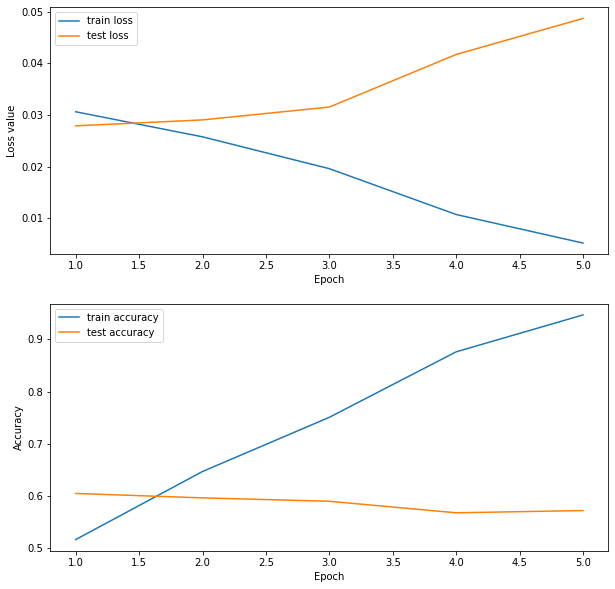

max acc: 60.469705940398654


In [ ]:
max_lr = 0.00005
weight_decay = 1e-4
n_epochs = 5

params = list(text_encoder.parameters()) + list(mlp_model.parameters()) + list(image_encoder.parameters())
optimizer = optim.Adam(params, max_lr, weight_decay=weight_decay)
sched = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=n_epochs, 
                                      steps_per_epoch=len(dataloaders['train']))

phases = ['train', 'test']
for e in range(n_epochs):
  epoch = len(accs_all['train']) + 1
  accs, losses = run_epoch(optimizer, dataloaders, sched=sched, phases=phases)
  for phase in phases:
    accs_all[phase].append(accs[phase])
    losses_all[phase].append(losses[phase])

  with open("hist_accs.pkl", "wb") as f:
    pickle.dump(accs_all, f)

  with open("hist_losses.pkl", "wb") as f:
    pickle.dump(losses_all, f)

  if accs_all['test'][-1] == max(accs_all['test']): 
    torch.save(image_encoder, os.path.join(project_root, 'phase3_part_a', f"best_image_encoder{1 + np.argmax(accs_all['test'])}_acc{max(accs_all['test'])}.pt"))
    torch.save(text_encoder, os.path.join(project_root, 'phase3_part_a', f"best_text_encoder{1 + np.argmax(accs_all['test'])}_acc{max(accs_all['test'])}.pt"))
    torch.save(mlp_model, os.path.join(project_root, 'phase3_part_a', f"best_mlp_model{1 + np.argmax(accs_all['test'])}_acc{max(accs_all['test'])}.pt"))

plot_history(losses_all, accs_all)
print(f"max acc: {100 * max(accs_all['test'])}")

In [ ]:
torch.save(image_encoder, os.path.join(project_root, 'phase3_part_a', f"best_image_encoder{1 + e}.pt"))
torch.save(text_encoder, os.path.join(project_root, 'phase3_part_a', f"best_text_encoder{1 + e}.pt"))
torch.save(mlp_model, os.path.join(project_root, 'phase3_part_a', f"best_mlp_model{1 + e}.pt"))

In [ ]:
image_encoder = torch.load(os.path.join(project_root, 'phase3_part_a', f"best_image_encoder1_acc0.60.pt"))
text_encoder = torch.load(os.path.join(project_root, 'phase3_part_a', f"best_text_encoder1_acc0.60.pt"))
mlp_model = torch.load(os.path.join(project_root, 'phase3_part_a', f"best_mlp_model1_acc0.60.pt"))

In [ ]:
y_true = []
y_predicted = []

with torch.no_grad():
    for images, texts, labels in tqdm(dataloaders['test']):
        images = images.to(device)
        labels = labels.to(device)
        texts = texts.to(device)

        image_embeddings = image_encoder(images)
        text_embeddings = text_encoder(texts)

        embedded = torch.cat((image_embeddings, text_embeddings), dim=1)

        predictions = mlp_model(embedded)

        y_true.extend(labels.tolist())
        y_predicted.extend(predictions.argmax(dim=1).tolist())

100%|██████████| 159/159 [01:59<00:00,  1.33it/s]


In [ ]:
y_true = np.array(y_true)
y_predicted = np.array(y_predicted)

Accuracy: 60.47%, F1 Accuracy: 60.78%


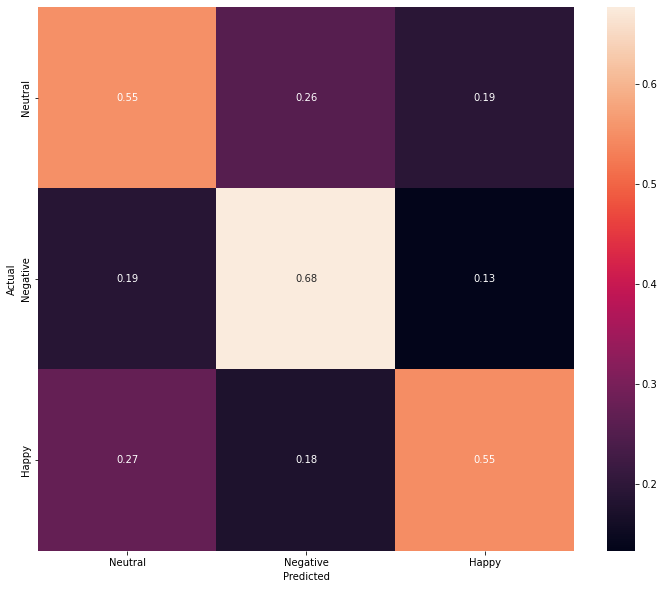

Predicted,Happy,Negative,Neutral,All
Actual,,,,
Happy,882,284,440,1606
Negative,287,1465,411,2163
Neutral,250,331,717,1298
All,1419,2080,1568,5067


In [ ]:
import pandas as pd
from sklearn.metrics import f1_score

def get_accuracy(y_true, y_pred):
    #print((y_true == y_pred))
    val = (1. * (y_true == y_pred)).mean()
    if isinstance(val, torch.Tensor):
      val = val.cpu().item()
    return val

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = get_accuracy(y_true, y_pred)
    if isinstance(y_true, torch.Tensor):
      y_true=y_true.cpu()
      y_pred=y_pred.cpu()
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return acc, f1

acc, f1_acc = acc_and_f1(y_true, y_predicted)
print(f'Accuracy: {acc*100:.2f}%, F1 Accuracy: {f1_acc*100:.2f}%')

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_predicted)

labels = ['Neutral', 'Negative', 'Happy']
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

y_test = [labels[i] for i in y_true]
y_pred = [labels[i] for i in y_predicted]


data = {'y_actual':    y_test,
        'y_predicted': y_pred
        }

df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'], margins=True)
print()
confusion_matrix